In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, RandomSampler
import numpy as np
from deep_feature_reweighting.wb_data import (
    WaterBirdsDataset,
    get_loader,
    get_transform_cub,
)
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
class IdxDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (idx, *self.dataset[idx])

In [3]:
DATA_FOLDER = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2"
CONCEPT_PATH = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/img_embeddings_thre10_vocab144.pickle"
VOCAB_PATH = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/vocab_thre10_144.pickle"
batch_size = 128
train_transform = get_transform_cub(
        target_resolution=(224, 224), train=True, augment_data=True
    )
test_transform = get_transform_cub(
    target_resolution=(224, 224), train=False, augment_data=False
)
trainset = WaterBirdsDataset(
        basedir=DATA_FOLDER,
        split="train",
        transform=train_transform,
        concept_embed=CONCEPT_PATH
    )
trainset_ref = WaterBirdsDataset(
        basedir=DATA_FOLDER,
        split="train",
        transform=test_transform,
        concept_embed=CONCEPT_PATH
    )
train_idx_dataset = IdxDataset(trainset_ref)
train_loader = DataLoader(
                trainset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )
ref_train_loader = DataLoader(
                train_idx_dataset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )

testset = WaterBirdsDataset(
    basedir=DATA_FOLDER,
    split="test",
    transform=test_transform,
    concept_embed=CONCEPT_PATH
)
test_loader = DataLoader(
                testset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )

/u/gz5hp/ml/lib/python3.10/site-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


11788
4795
11788
4795
11788
5794


In [4]:
device  = "cuda:0"
model = torchvision.models.resnet50(weights=None)
d = model.fc.in_features
model.fc = torch.nn.Linear(d, 2)
ckpt_path = "/bigtemp/gz5hp/spurious_correlations/dfr_ckpts/waterbirds/erm_seed1/final_checkpoint.pt"
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
def get_correlated_features(model, dataloader):
    class_wise_data = {}
    model.eval()
    with torch.no_grad():
        for idx, data, y, _, _, _ in tqdm(dataloader):
            logits = model(data.to(device))
            logits = logits.detach().cpu()
            preds = torch.argmax(logits, dim=1).numpy()
            for i in range(len(y)):
                l = y[i].item()
                if l in class_wise_data:
                    class_wise_data[l].append((idx[i].item(),int(preds[i]==l)))
                else:
                    class_wise_data[l] = [(idx[i].item(),int(preds[i]==l))]
    embeddings = dataloader.dataset.dataset.embeddings  
    class_correlated_feas = {}
    for c in class_wise_data:
        num_per_class = len(class_wise_data[c])
        counts_pos_w = np.zeros(embeddings.shape[1])
        counts_neg_w = np.zeros(embeddings.shape[1])
        
        counts_pos_wo = np.zeros(embeddings.shape[1])
        counts_neg_wo = np.zeros(embeddings.shape[1])
        for idx, pred_res in class_wise_data[c]:
            if pred_res == 1:
                counts_pos_w[embeddings[idx] == 1] += 1
                counts_pos_wo[embeddings[idx] != 1] += 1
            else:
                counts_neg_w[embeddings[idx] == 1] += 1
                counts_neg_wo[embeddings[idx] != 1] += 1
                
            
        indexes = np.arange(embeddings.shape[1])
        active_feas = indexes[(counts_pos_w + counts_neg_w) > 0]
        total_w = counts_pos_w[active_feas] + counts_neg_w[active_feas]
        probs_w = counts_pos_w[active_feas] / total_w
        
        total_wo = counts_pos_wo[active_feas] + counts_neg_wo[active_feas]
        probs_wo = counts_pos_wo[active_feas] / (total_wo + 1e-10)
        
        scores = np.tanh(abs(np.log(probs_w / (probs_wo+1e-10)+1e-10)))
        class_correlated_feas[c] = (scores, active_feas)
    return class_correlated_feas      
    
    

In [6]:
with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)


In [7]:
class_correlated_feas = get_correlated_features(model, ref_train_loader)

100%|██████████| 38/38 [00:10<00:00,  3.60it/s]


In [8]:
fea_indexes = class_correlated_feas[1][1][np.argsort(class_correlated_feas[1][0])]
[vocab[i] for i in fea_indexes]

['white:adj',
 'large:adj',
 'bird:noun',
 'top:noun',
 'duck:noun',
 'person:noun',
 'beach:noun',
 'black:adj',
 'water:noun',
 'woman:noun',
 'seagull:noun',
 'body:noun',
 'colorful:adj',
 'flower:noun',
 'bike:noun',
 'pole:noun',
 'head:noun',
 'dirt:noun',
 'post:noun',
 'dirt road:noun',
 'elephant:noun',
 'giraffe:noun',
 'picnic:noun',
 'flower pot:noun',
 'beak:noun',
 'long:adj',
 'picnic table:noun',
 'metal:noun',
 'city:noun',
 'bunch:noun',
 'pot:noun',
 'sidewalk:noun',
 'red:adj',
 'leave:noun',
 'skateboard:noun',
 'horse:noun',
 'ground:noun',
 'boy:noun',
 'wall:noun',
 'back:noun',
 'grass field:noun',
 'wood:noun',
 'waterfall:noun',
 'polar:adj',
 'sand:noun',
 'table:noun',
 'crowd:noun',
 'ledge:noun',
 'day:noun',
 'mountain:noun',
 'hillside:noun',
 'cat:noun',
 'bridge:noun',
 'umbrella:noun',
 'fish:noun',
 'palm tree:noun',
 'palm:noun',
 'dry:adj',
 'sky:noun',
 'flock:noun',
 'blue:adj',
 'mouth:noun',
 'side:noun',
 'little:adj',
 'wooden:adj',
 'girl:

<BarContainer object of 116 artists>

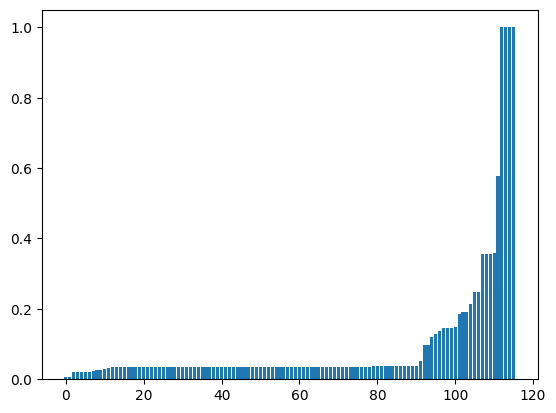

In [9]:
plt.bar(np.arange(len(class_correlated_feas[1][0])), np.sort(class_correlated_feas[1][0]))

In [10]:

class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()
    def forward(self, x):
        return x
class UnlearnModel(nn.Module):
    def __init__(self):
        super(UnlearnModel, self).__init__()
        model = torchvision.models.resnet50(weights=None)
        d = model.fc.in_features
        identity_layer = IdentityModel()
        self.backbone = model
        self.backbone.fc = identity_layer
        
        self.classifier = nn.Linear(d, 2)
        self.fea_decoder = nn.Sequential(nn.Linear(d, 256), nn.ReLU(), nn.Linear(256, 2))
    def unlearn(self, x):
        with torch.no_grad():
            fea = self.backbone(x)
        dec = self.fea_decoder(fea)
        return dec
    def forward(self, x):
        fea = self.backbone(x)
        dec = self.fea_decoder(fea)
        logits = self.classifier(fea)
        return logits, dec
umodel = UnlearnModel()
umodel.backbone.load_state_dict(torch.load(ckpt_path), strict=False)
umodel.to(device)
        

UnlearnModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [11]:
           
class DecoderDataset(Dataset):
    def __init__(self, dataset, feature_indexes):
        self.dataset = dataset
        all_indexes = np.arange(len(dataset.embeddings))
        sel_indexes = []
        labels = []
        features = []
        for c in feature_indexes:
            features.append(feature_indexes[c])
        features = np.unique(np.concatenate(features))
        self.labels = np.zeros(len(all_indexes),dtype=np.int64)
        cond = dataset.embeddings[:,features].sum(axis=1) > 0
        indexes = all_indexes[cond]
        self.labels[indexes] = 1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx][0], self.labels[idx]


# learn the feature decoder
fea_indexes = {}
for c in class_correlated_feas:
    indexes = class_correlated_feas[c][1][np.argsort(class_correlated_feas[c][0])]
    fea_indexes[c] = indexes[-10:]
decoder_dataset = DecoderDataset(trainset, fea_indexes)
decoder_train_loader = DataLoader(
                decoder_dataset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )

    

In [12]:
umodel.eval()
umodel.fea_decoder.train()
loss_func = nn.CrossEntropyLoss()
decoder_optimizer = torch.optim.SGD(
        umodel.fea_decoder.parameters(), lr=5.e-4, momentum=0.9, weight_decay=1e-4
)
for epoch in range(50):
    loss_avg = 0.0
    acc_avg = 0.0
    counts = 0
    for data, y in tqdm(decoder_train_loader):
        data = data.to(device)
        y = y.to(device)
        dec = umodel.unlearn(data)
        loss = loss_func(dec, y)
        decoder_optimizer.zero_grad()
        loss.backward()
        decoder_optimizer.step()
        loss_avg += loss.item()
        counts += len(y)
        corrects = (torch.argmax(dec, dim=1) == y).sum().item()
        acc_avg += corrects
    acc_avg /= counts
    loss_avg /= counts
    print(f"Epoch {epoch} loss {loss_avg:.4f} acc_avg {acc_avg:.4f}")
    

100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Epoch 0 loss 0.0045 acc_avg 0.6813


100%|██████████| 38/38 [00:07<00:00,  4.81it/s]


Epoch 1 loss 0.0037 acc_avg 0.8121


100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


Epoch 2 loss 0.0035 acc_avg 0.8257


100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Epoch 3 loss 0.0035 acc_avg 0.8288


100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Epoch 4 loss 0.0034 acc_avg 0.8300


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch 5 loss 0.0034 acc_avg 0.8298


100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


Epoch 6 loss 0.0034 acc_avg 0.8313


100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


Epoch 7 loss 0.0034 acc_avg 0.8313


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


Epoch 8 loss 0.0034 acc_avg 0.8338


100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


Epoch 9 loss 0.0034 acc_avg 0.8346


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


Epoch 10 loss 0.0033 acc_avg 0.8338


100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Epoch 11 loss 0.0033 acc_avg 0.8365


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch 12 loss 0.0033 acc_avg 0.8359


100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


Epoch 13 loss 0.0033 acc_avg 0.8386


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 14 loss 0.0033 acc_avg 0.8375


100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


Epoch 15 loss 0.0033 acc_avg 0.8375


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 16 loss 0.0032 acc_avg 0.8386


100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Epoch 17 loss 0.0032 acc_avg 0.8409


100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


Epoch 18 loss 0.0032 acc_avg 0.8409


100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


Epoch 19 loss 0.0032 acc_avg 0.8423


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 20 loss 0.0032 acc_avg 0.8415


 68%|██████▊   | 26/38 [00:05<00:02,  5.11it/s]

In [ ]:
#unlearn the selected features
umodel.train()
umodel.fea_decoder.eval()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
        list(umodel.backbone.parameters())+list(umodel.classifier.parameters()), lr=1.e-5, momentum=0.9, weight_decay=1e-4
)
for epoch in range(50):
    loss_avg = 0.0
    acc_avg = 0.0
    counts = 0
    for data, y, _, _, _ in tqdm(train_loader):
        data = data.to(device)
        y = y.to(device)
        ref_y = (torch.ones(len(y),2)/2.0).to(device)
        logits, dec = umodel(data)
        loss1 = loss_func(logits, y)
        loss2 = loss_func(dec, ref_y)
        loss = loss1 + loss2 * 0.1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        counts += len(y)
        corrects = (torch.argmax(logits, dim=1) == y).sum().item()
        acc_avg += corrects
    acc_avg /= counts
    loss_avg /= counts
    print(f"Epoch {epoch} loss {loss_avg:.4f} acc_avg {acc_avg:.4f}")
umodel.fea_decoder.train()
loss_func = nn.CrossEntropyLoss()


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 0 loss 0.0050 acc_avg 0.7791


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 1 loss 0.0045 acc_avg 0.7677


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 2 loss 0.0044 acc_avg 0.7679


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 3 loss 0.0043 acc_avg 0.7679


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 4 loss 0.0042 acc_avg 0.7679


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 5 loss 0.0041 acc_avg 0.7691


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 6 loss 0.0041 acc_avg 0.7731


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 7 loss 0.0040 acc_avg 0.7773


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 8 loss 0.0040 acc_avg 0.7860


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 9 loss 0.0039 acc_avg 0.7975


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 10 loss 0.0039 acc_avg 0.8113


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 11 loss 0.0038 acc_avg 0.8190


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 12 loss 0.0038 acc_avg 0.8317


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 13 loss 0.0038 acc_avg 0.8413


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 14 loss 0.0037 acc_avg 0.8473


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 15 loss 0.0037 acc_avg 0.8540


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 16 loss 0.0037 acc_avg 0.8599


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 17 loss 0.0037 acc_avg 0.8651


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 18 loss 0.0036 acc_avg 0.8669


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]

Epoch 19 loss 0.0036 acc_avg 0.8690


In [ ]:
def test_model(model, loader):
    count = 0
    acc = 0
    model.eval()
    res = []
    groups = []
    with torch.no_grad():
        for x, y, g, p, _ in loader:
            x, y = (
                x.to(device),
                y.to(device),
            )  # 1 for water; 0 for land. 1 for seabird; 0 for landbird.
            out, _ = model(x)
            pred = (torch.argmax(out, dim=-1) == y).detach().cpu().numpy()
            res.append(pred)
            groups.append(g.detach().cpu().numpy())
    res = np.concatenate(res)
    groups = np.concatenate(groups)
    avg_acc = res.sum() / len(res)
    acc_group = []
    group_num = []
    for g in np.unique(groups):
        gres = res[groups == g]
        acc_group.append(gres.sum() / len(gres))
        group_num.append(len(gres))
    acc_group = np.array(acc_group)
    worst_acc = acc_group.min()
    # print(group_num)
    return avg_acc, worst_acc

In [ ]:
avg_acc, worst_acc = test_model(umodel, test_loader)
print(f"avg_acc {avg_acc:.4f} worst_acc {worst_acc:.4f}")

avg_acc 0.9261 worst_acc 0.5935


In [ ]:
# single decoder layer: avg_acc 0.9113 worst_acc 0.5576 (20, 20)
# two-layer decoder: avg_acc 0.9261 worst_acc 0.5935 (20, 20)